In [ ]:
# import pykonal
import glob
import segyio
# import segysak

import numpy as np
# import xarray as xr
from tqdm import tqdm
from devito import configuration, VectorTimeFunction, TensorTimeFunction, Eq, Operator
from examples.seismic import AcquisitionGeometry
from elastic_custom import ElasticWaveSolver
# from scratch.util import CreateSeismicModelElastic, nn_interp_coords
from devito import div, grad, diag, solve
from matplotlib import pyplot as plt
from examples.seismic.source import RickerSource, Receiver, TimeAxis, PointSource
from examples.seismic import SeismicModel, plot_velocity, demo_model, source

#Закоменти, чтобы выполнять на CPU
# from devito import configuration
# configuration['ignore-unknowns'] = True
#(a) using one GPU
#(b) using multi-GPUs with MPI (requires turning the notebook into a python script)
# configuration['platform'] = 'nvidiaX'
# configuration['compiler'] = 'pgcc'
# configuration['language'] = 'openacc'

ModuleNotFoundError: No module named 'elastic_custom'

In [51]:
nummodel = "AMT"

In [52]:
def CreateSeismicModelElastic(vp, vs, rho, origin, spacing, shape, so, nbl, bcs='damp'):

    model = demo_model(preset='layers-elastic', nlayers=3, shape=shape, spacing=spacing,
                   space_order=so, origin = origin, nbl = nbl, fs=True)


    rho_data_nozero = np.where(rho == 0, 1, rho)
    
    model.update('vp', vp)
    model.update('vs', vs)
    model.update('b', 1/rho_data_nozero)
    # model = SeismicModel(space_order=so, vp=vp, vs=vs, b=1/rho_data_nozero,
    #                         origin=origin, shape=shape,
    #                         dtype=np.float32, spacing=spacing, nbl=nbl, bcs='damp',
    #                      # fs=True,
    #                     )
    model._initialize_physics(vp=vp,
                              vs=vs,
                              b=model.b.data[nbl:-nbl, nbl:-nbl],
                              space_order=so
                             )
    
    return model

In [53]:
model = np.load(f"Model_{nummodel}.npz")
model['xx'].shape

(381, 381)

In [54]:
# привычный формат

vp_data = model['vp'].T/1000
vs_data = vp_data*0.5
rho_data = vp_data*0+1.8
# Верхний слой со свойствами воды
# rho_data[rho_data==0] = 1.
# vp_data[vp_data==0] = 1.5
# vs_data[vs_data==0] = 0.0

# сетка
spacing = (0.5, 0.5) # z из header_rho.loc["TRACE_SAMPLE_INTERVAL", "mean"]
origin = (0, 0)
nbl = 100
so = 8

# модель
model = CreateSeismicModelElastic(origin=origin,
                       spacing=spacing,
                       shape=vp_data.shape,
                       vp=vp_data,
                       vs=vs_data,
                       rho=rho_data,
                       so=so, 
                       nbl=nbl,
                       bcs='mask',
                      )

print(model)

Operator `initdamp` ran in 0.01 s


In [55]:
# model.damp.data[:, :] = 1 - model.damp.data[:, :]
model.damp.data[:, :100] = model.damp.data[:, 101][:, None]
# model.damp.data[nbl:-nbl, :100] = 0.
# model.damp.data[100:, :100] = 0.

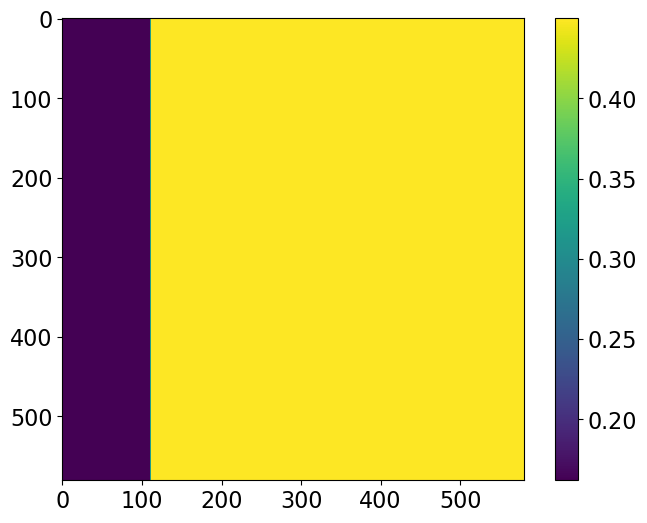

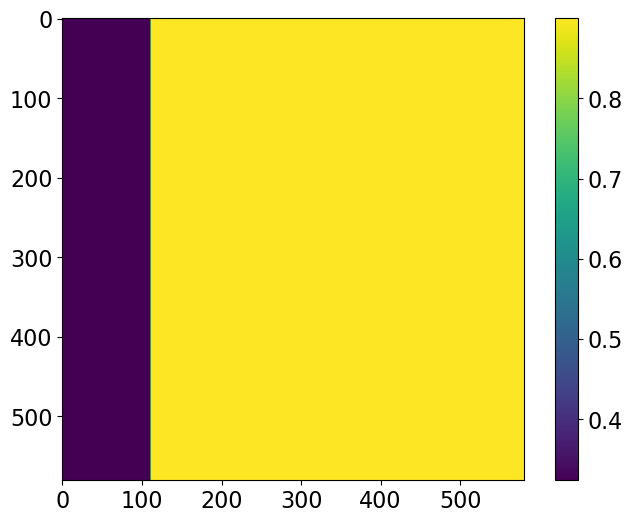

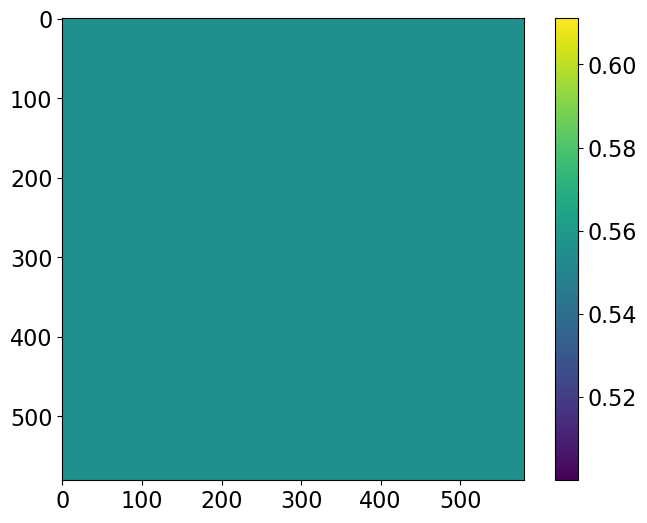

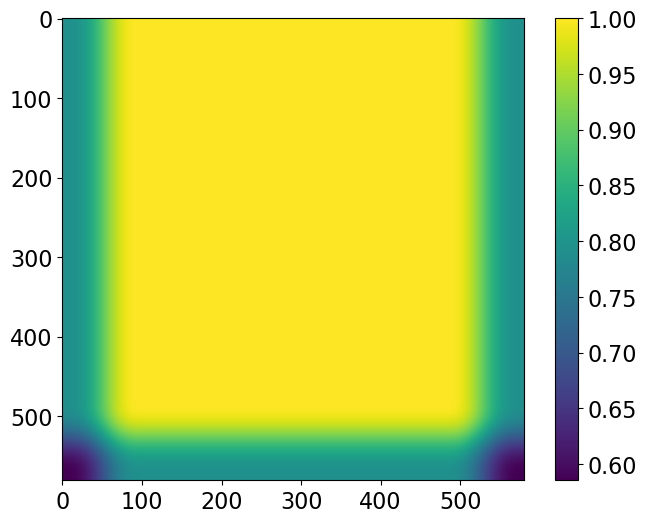

In [56]:
plt.imshow(model.mu.data)
plt.colorbar()
plt.show()

plt.imshow(model.lam.data)
plt.colorbar()
plt.show()

plt.imshow(model.b.data)
plt.colorbar()
plt.show()

plt.imshow(model.damp.data.T)
plt.colorbar()
plt.show()

In [57]:
t0=0.
tn=1024.
dt = model.critical_dt/2
time_range = TimeAxis(start=t0, stop=tn, step=dt)
f0 = 0.05

nsrc = 96

src_coordinates = np.empty((nsrc, 2))
src_coordinates[:, 0] = np.arange(0,192,2)
src_coordinates[:, 1] = 0.

In [58]:
wavelet =  np.loadtxt("wavelet.txt")

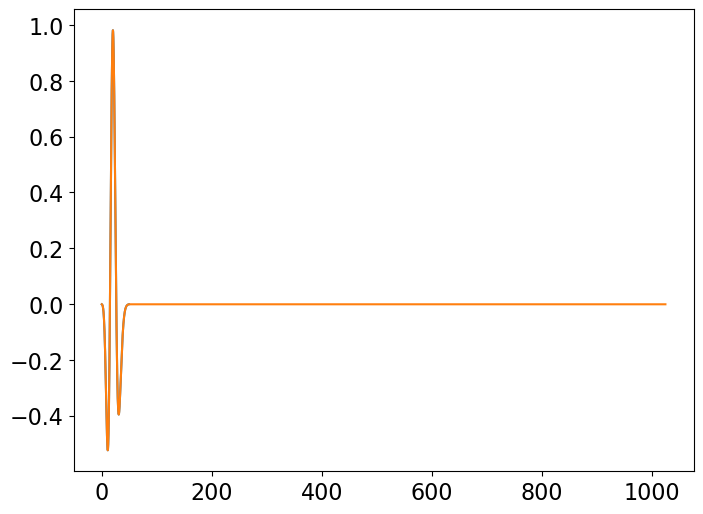

In [59]:
dt_w = 1/(359*25)
t_w = np.arange(0, 360*dt, dt)
plt.plot(t_w, -wavelet)
wavelet_i = np.interp(time_range.time_values, t_w, -wavelet)
plt.plot(time_range.time_values, wavelet_i)
plt.show()

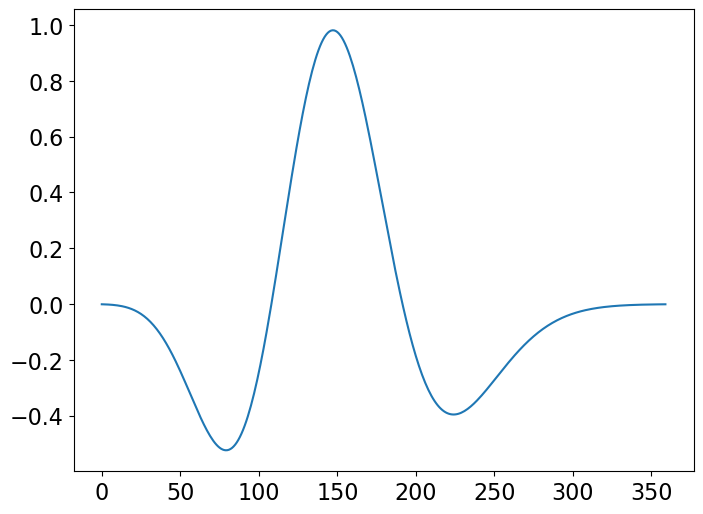

In [60]:
plt.plot(-wavelet)
# plt.xlim([0, 25])
# plt.axvline(2)
plt.show()

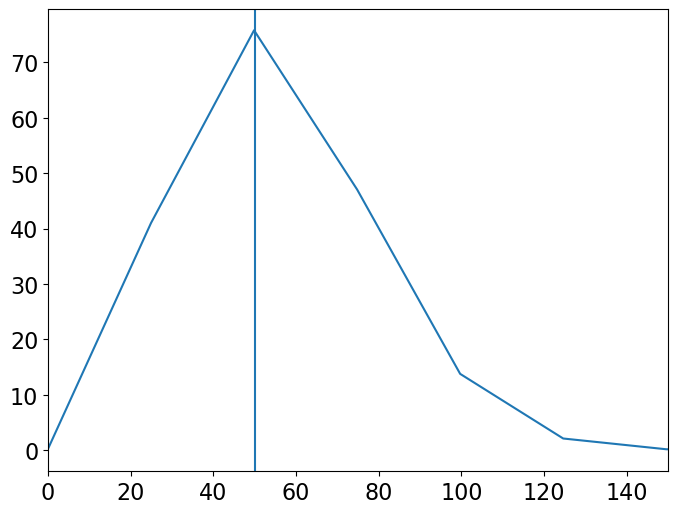

In [61]:
from scipy.fft import rfft, rfftfreq
wS = rfft(wavelet)
plt.plot(rfftfreq(wavelet.size, dt_w), np.abs(wS))
plt.xlim([0, 150])
plt.axvline(50)
plt.show()

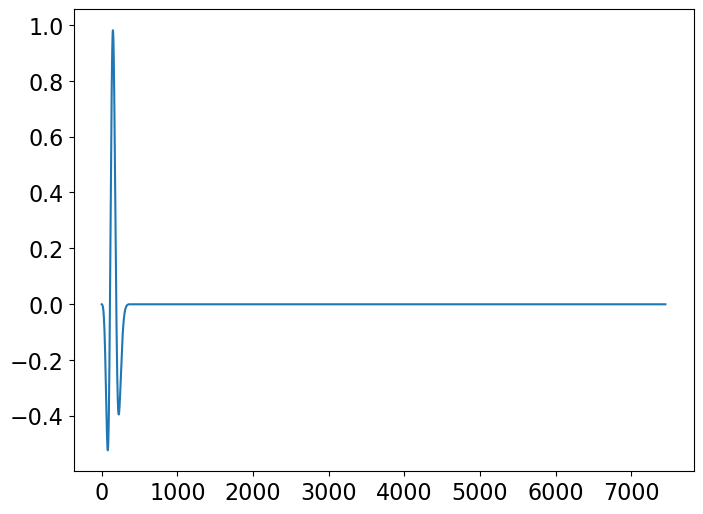

In [62]:
src = PointSource(name='src', grid = model.grid, time_range=time_range, npoint=1)
src.data[:, 0]=wavelet_i
src.coordinates.data[:] = src_coordinates[0]
plt.plot(src.data[:, 0])

Starting operator


  0%|                                                    | 0/96 [00:00<?, ?it/s]

Source -  0 ; Coordinate -  [0. 0.]


Operator `ForwardElastic` ran in 6.99 s


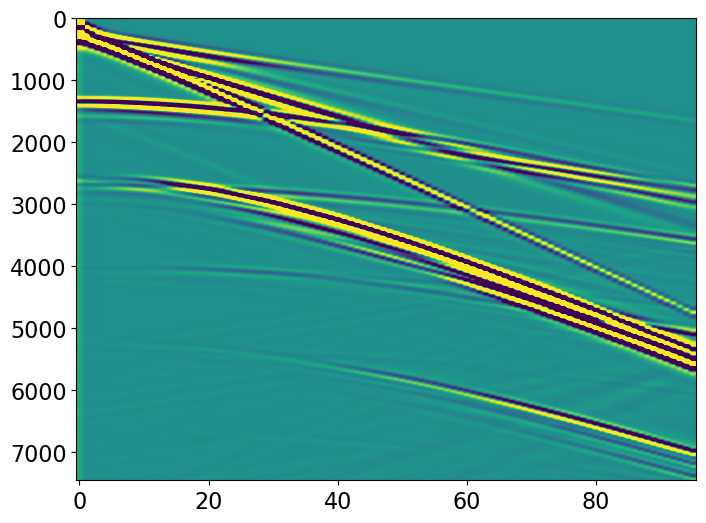

/home/andrey/anaconda3/lib/python3.12/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
  1%|▍                                           | 1/96 [00:08<13:23,  8.46s/it]

Source -  1 ; Coordinate -  [2. 0.]


Operator `ForwardElastic` ran in 7.03 s


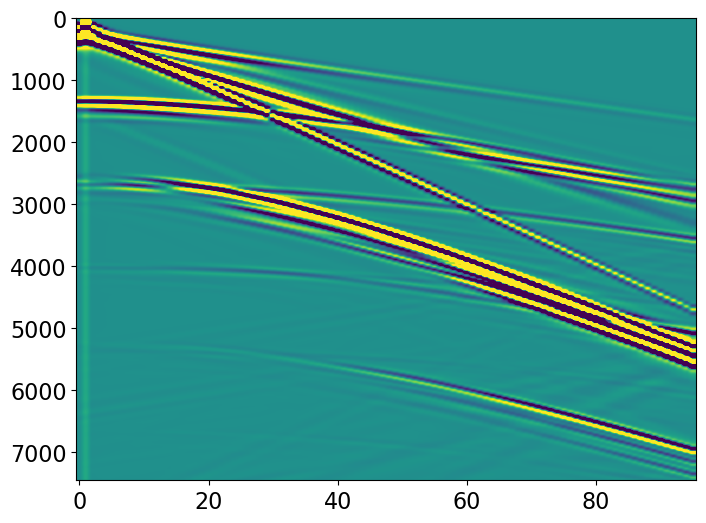

/home/andrey/anaconda3/lib/python3.12/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
  2%|▉                                           | 2/96 [00:16<13:16,  8.47s/it]

Source -  2 ; Coordinate -  [4. 0.]


Operator `ForwardElastic` ran in 6.97 s


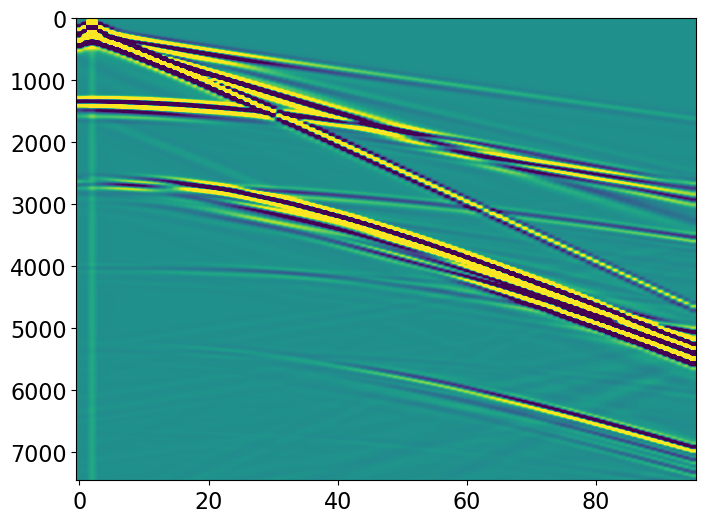

/home/andrey/anaconda3/lib/python3.12/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
  3%|█▍                                          | 3/96 [00:25<13:01,  8.40s/it]

Source -  3 ; Coordinate -  [6. 0.]


  3%|█▍                                          | 3/96 [00:33<17:11, 11.09s/it]


KeyboardInterrupt: 

In [63]:
# nsrc = 2
# src_coordinates = np.empty((nsrc, 2))
# src_coordinates[:] = ((df_ins['X'][159], 0), (df_ins['X'][100], 0))


nrec = 96
rec_coordinates = np.empty((nrec, 2))
rec_coordinates[:,0] = np.arange(0,192,2)
rec_coordinates[:,1] = 0.

# тензоры

space_order = 8
print('Starting operator')
for i, src_coords in enumerate(tqdm(src_coordinates)):
    print('Source - ', i, '; Coordinate - ', src_coords)

    # src = RickerSource(name='src', grid = model.grid, f0=f0, time_range=time_range, npoint=1)
    # src.coordinates.data[:] = src_coords

    src = PointSource(name='src', grid = model.grid, time_range=time_range, npoint=1)
    src.data[:, 0]=wavelet_i
    src.coordinates.data[:] = src_coords
    
    v = VectorTimeFunction(name='v', grid=model.grid,
                           space_order=space_order, time_order=2)
    tau = TensorTimeFunction(name='tau', grid=model.grid,
                             space_order=space_order, time_order=2)

    lam, mu, b = model.lam, model.mu, model.b

    eq_v = v.dt - b * div(tau)
    # Stress
    e = (grad(v.forward) + grad(v.forward).transpose(inner=False))
    eq_tau = tau.dt - lam * diag(div(v.forward)) - mu * e

    u_v = Eq(v.forward, model.damp * solve(eq_v, v.forward))
    u_t = Eq(tau.forward, model.damp * solve(eq_tau, tau.forward))

    s = model.grid.time_dim.spacing
    # Source symbol with input wavelet

    rec1 = Receiver(name="rec1", grid=model.grid, npoint=nrec, time_range=time_range)
    rec1.coordinates.data[:,0] = np.arange(0,192,2)
    rec1.coordinates.data[:,1] = 0.

    rec2 = Receiver(name="rec2", grid=model.grid, npoint=nrec, time_range=time_range)
    rec2.coordinates.data[:,0] = np.arange(0,192,2)
    rec2.coordinates.data[:,1] = 0.
    
    rec_term1 = rec1.interpolate(expr=v[0])
    rec_term2 = rec2.interpolate(expr=v[1])
    # The source injection term
    src_expr = src.inject(tau.forward[1, 1], expr=src * s)

    srcrec = src_expr + rec_term1 + rec_term2
    op = Operator([u_v] + [u_t] + srcrec, subs=model.spacing_map, name="ForwardElastic",
                  # opt=('noop', {'openmp': True}),
                 )
    summary = op.apply(dt=dt)
    # выгрузка в sgy
    dt_r = 0.5

    plt.imshow(rec2.data, vmin=-1e-3, vmax=1e-3)
    plt.gca().set_aspect('auto',)
    plt.show()
    # inheader = segysak.segy.segy_header_scrape(scenario+'/Vs_smooth_2D')
    rec1 = rec1.resample(dt=dt_r)
    rec2 = rec2.resample(dt=dt_r)
    
    namexx = f'./Results/Surface_{nummodel}/Vx-'+str(int(src_coords[0]))+'.sgy'
    namezz = f'./Results/Surface_{nummodel}/Vz-'+str(int(src_coords[0]))+'.sgy'

    for name, recxz in zip([namexx, namezz], [rec1, rec2]):
        segyio.tools.from_array2D(name, recxz.data.T, dt=dt_r*10**3)
        with segyio.open(name, 'r+') as f:
            for j in range(len(f.header)):
                f.header[j] = {segyio.TraceField.SourceGroupScalar : -100,
                               segyio.TraceField.SourceX : int(src_coords[0]*100),
                               segyio.TraceField.GroupX : int(rec_coordinates[i, 0]*100),
                               # segyio.TraceField.ReceiverGroupElevation : int(rec_coordinates[j,1]*100),
                              }

In [ ]:
plt.imshow(rec2.data, vmin=-1e-3, vmax=1e-3)
plt.gca().set_aspect('auto')
plt.show()

In [ ]:
rec1.data